In [1]:
from datetime import datetime
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
START_DATE = '2019-01-01'
RPGF2_DATE = '2023-04-01'
END_DATE = '2023-10-01'

OP_RED = "#FF0420"
OP_MED_RED = "#FF6969"
OP_LIGHT_RED = "#FFCCDD"

plt.rcParams['figure.dpi'] = 144
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['savefig.facecolor']= 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'sans-serif']

In [3]:
path = "csv/RetroPGF3 Results - ConsolidatedData.csv"
consolidated_df = pd.read_csv(path, index_col=0)

projects_to_exclude = [
    "Protocol Guild",       # has very high overlap with major Ethereum repos like go-ethereum
    "Optimistic Indexer",   # a repo owned by Polynomial Protocol with minimal GitHub activity
    "Infinity Wallet",      # project did not list any OSS repos in its application
]
consolidated_df = consolidated_df[~consolidated_df['Meta: Project Name'].isin(projects_to_exclude)]
consolidated_df.shape

(640, 56)

In [4]:
consolidated_df.iloc[0]

Result: # Ballots                                                                    101
Result: Median OP                                                               500000.0
Result: Quorum Reached                                                              True
Result: Received OP                                                            496896.42
Meta: Project Name                                                           go-ethereum
Meta: Applicant Type                                                             PROJECT
Meta: Website                                    https://github.com/ethereum/go-ethereum
Meta: Bio                                             An Ethereum execution layer client
Meta: Payout Address                          0x0000006916a87b82333f4245046623b23794C65C
Category: Collective Governance                                                        0
Category: Developer Ecosystem                                                          1
Category: End User Ex

In [5]:
code_vectors = [
    "OSO: Avg Monthly Active Devs Last 6 Months",
    "OSO: Contributors Last 6 Months",
    "OSO: Total Forks",
    "OSO: Total Stars",
    "OSO: Downloads Last 6 Months"
]
onchain_vectors = [
    "OSO: Total Txn Fees (ETH)",    
    "OSO: Total Txns",
    "OSO: Onchain Users Last 6 Months"    
]
vectors_list = code_vectors + onchain_vectors
vector_names = [
    ("Grow full-time developers", "full-time developer months since the project's first commit"),
    ("Expand the open source community", "GitHub users who made their contribution in the last 6 months"),
    ("Support modular, permissionless contributions", "highest fork count among repos owned by the project"),
    ("Be beloved in the OP community", "stars received from other developers in the OP community"),
    ("Make it easier to build awesome apps", "NPM downloads over last 6 months, all packages"),
    ("Grow sequencer fees", "all-time OP ETH contribution"),
    ("Increase onchain activity", "all-time transactions on OP Mainnet"),
    ("Grow ‘high value’ users", "active, recent, multi-app users on OP Mainnet")
]

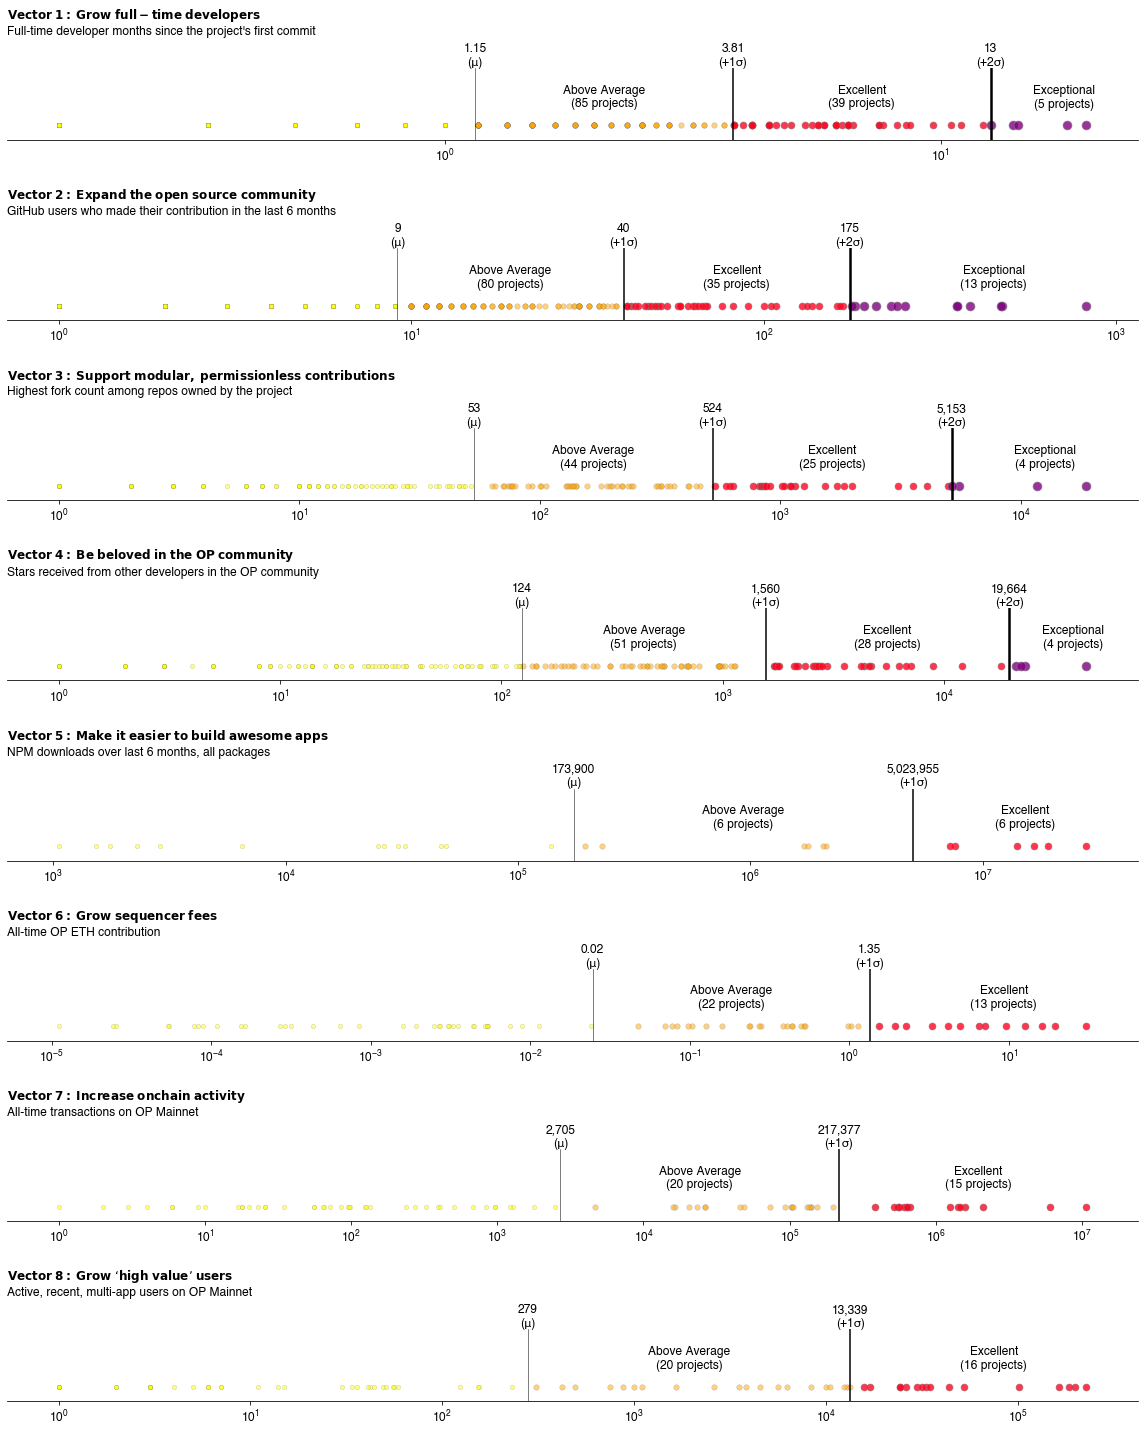

In [6]:
W,H = 16,20

fig, axes = plt.subplots(figsize=(W,H), ncols=1, nrows=8, facecolor='white')

def impact_vector(col_name, ax, method='kde', title=None):
    
    series = consolidated_df[col_name].copy()
    vector = series[series>=0.00001].dropna()        
    logvector = np.log(vector).sort_values(ascending=False)
    
    mu = logvector.mean()
    sigma = logvector.std()
    
    mean = np.exp(mu)
    sig1 = np.exp(mu+sigma)
    sig2 = np.exp(mu+sigma*2)
    
    v1 = vector[vector<=mean]
    v2 = vector[(vector>mean) & (vector<sig1)]
    v3 = vector[(vector>=sig1) & (vector<sig2)]
    v4 = vector[vector>=sig2]
    
    if not ax:
        fig, ax = plt.subplots(figsize=(W,H/8), facecolor='white')
        
    if method == 'kde':
        sns.kdeplot(vector, ax=ax, color=OP_RED, log_scale=True)

    else:
        sns.scatterplot(x=v1, y=[0]*len(v1), s=20, color='yellow', alpha=.5, edgecolor='grey', ax=ax)
        sns.scatterplot(x=v2, y=[0]*len(v2), s=30, color='orange', alpha=.5, edgecolor='grey', ax=ax)
        sns.scatterplot(x=v3, y=[0]*len(v3), s=50, color=OP_RED, alpha=.8, edgecolor='grey', ax=ax)
        if len(v4):
            sns.scatterplot(x=v4, y=[0]*len(v4), s=80, color='purple', alpha=.8, edgecolor='grey', ax=ax)
        ax.set_xscale('log')
        ax.set_ylim(-1,4)

    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    
    style_lines = dict(ha='center', va='bottom', fontsize=12)
    style_divs = dict(ha='center', va='center', fontsize=12)
    
    ax.axvline(x=mean, color='black', lw=.5)
    if mean >= 5:
        ax.text(x=mean, y=ymax, s=f"{mean:,.0f}\n(μ)", **style_lines)
    else:
        ax.text(x=mean, y=ymax, s=f"{mean:,.2f}\n(μ)", **style_lines)        
    x = np.exp((np.log(mean) + np.log(sig1))/2)
    ax.annotate(f"Above Average\n({len(v2)} projects)", xy=(x, ymax/2), **style_divs)

    ax.axvline(x=sig1, color='black', lw=1.5)    
    if sig1 >= 5:
        ax.text(x=sig1, y=ymax, s=f"{sig1:,.0f}\n(+1σ)", **style_lines)
    else:
        ax.text(x=sig1, y=ymax, s=f"{sig1:,.2f}\n(+1σ)", **style_lines)
    x = np.exp((np.log(sig1) + np.log(min(sig2,xmax)))/2)
    ax.annotate(f"Excellent\n({len(v3)} projects)", xy=(x, ymax/2), **style_divs)

    if len(vector[vector >= sig2]):
        ax.axvline(x=sig2, color='black', lw=2.5)
        ax.text(x=sig2, y=ymax, s=f"{sig2:,.0f}\n(+2σ)", **style_lines)
        x = np.exp((np.log(sig2) + np.log(xmax))/2)
        ax.annotate(f"Exceptional\n({len(v4)} projects)", xy=(x, ymax/2), **style_divs)
        
    ax.minorticks_off()
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_ylabel("")

    if not title:
        title = col_name
    ax.set_title(title+"\n\n", loc='left', fontsize=12, fontweight='bold')

    def scorer(x):
        p = (x-mu)/sigma 
        if  p >= 2:
            return 1.5
        elif p >= 1:
            return 1.0
        elif p >= 0.5:
            return 0.25
        else:
            return 0
        
    scores = logvector.apply(scorer)    
    scores.name = f"Vector: {col_name}"
    
    return scores

def set_bold(txt): 
    return r"$\bf{" + str(txt) + "}$"

def make_title(i):
    vector_num = f"Vector {i+1}"
    name, measure = vector_names[i]
    name = f"{vector_num}: {name}"
    name = " ".join([set_bold(s) for s in name.split()])
    measure = measure[0].upper() + measure[1:]
    return f"{name}\n{measure}"


dfs = [
    impact_vector(v, axes[i], method='line', title=make_title(i)) 
    for i,v in enumerate(vectors_list)
]
vectors = pd.concat(dfs, axis=1)
vectors['Score'] = vectors.sum(axis=1)
df = (
    consolidated_df[['Meta: Project Name', 'Result: Received OP', 'Result: # Ballots']]
    .join(vectors)
    .fillna(0)
)
df = df[df['Score']>0]

fig.tight_layout()
fig.subplots_adjust(hspace=1.5)

In [7]:
results = {}
for v in df.columns[3:11]:
    results[v.replace(" OSO:","")] = df[df[v]>=1]['Result: Received OP'].mean()
results    

{'Vector: Avg Monthly Active Devs Last 6 Months': 131765.95318181821,
 'Vector: Contributors Last 6 Months': 176666.67770833333,
 'Vector: Total Forks': 200536.63413793105,
 'Vector: Total Stars': 187714.6096875,
 'Vector: Downloads Last 6 Months': 233044.42166666666,
 'Vector: Total Txn Fees (ETH)': 95792.22615384615,
 'Vector: Total Txns': 86962.63666666666,
 'Vector: Onchain Users Last 6 Months': 93885.72062499999}